# What Can Be Learned From a Basic Quantum Classification Model?

By: Samir Chawla<br>
Original Publication Date: Tuesday June 7, 2022

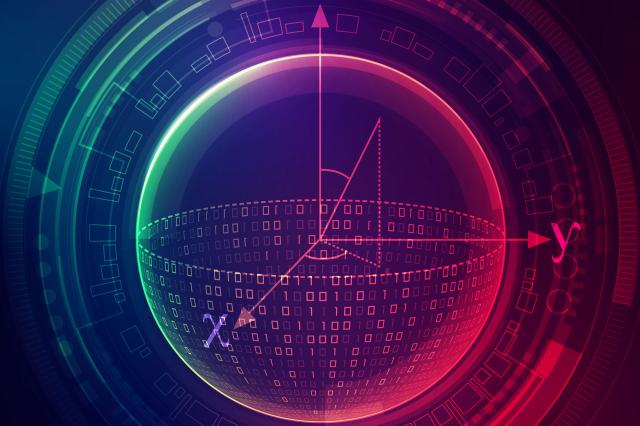

### Background Information

Quantum computing and specifically quantum machine learning is still very early in development. Generally speaking, publicly known quantum technology has not yet reached the point of "quantum supremacy" which is the point quantum computers have reached a point of usefullness for real world applications. 


Classical machine learning solves today's real world problems quite well but there is hope that quantum computing and machine learning will be able to tackle problems that require extremely powerful capablilities currently out of reach such as encryption and in chemistry.

### Description of this Research Project in Quantum Machine Learning

We will be using the quantum machine learning library by Google called cirq (https://quantumai.google/cirq) to solve a typical (and classical) classification problem.

The cirq library actually creates a quantum simulator instead of processing the data on a real quantum computer. For access to a real quantum computer, IBM currently provides access through their qiskit library (https://qiskit.org) that I may use for a follow-up project in quantum machine learning.

For this project we will us an image dataset of open and closed eyes to see how well cirq is able to correctly classify images. Please keep in mind that due to qubit restraints we will be using very scaled down images.

### Install and Import Libraries

In [2]:
# installing TensorFLow Version 2.3.1
from IPython.display import clear_output

# install tensorflow quantum
!pip install -q tensorflow_quantum

#install cirq
!pip install cirq

import tensorflow as tf

# Data Processing tools
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import os
import cv2
from PIL import Image

# QML tools
import tensorflow_quantum as tfq
import cirq
import sympy

# Visualization Tools
from cirq.contrib.svg import SVGCircuit
import matplotlib.pyplot as plt

clear_output()

### Initiatialize Arrays for Images and Labels and then Import the Images into the Array

In [3]:
# Load the train and test images from the seperate folders

TEMP_IMAGE_SIZE = 56
PROCESS_IMAGE_SIZE = 3
IMAGE_SHAPE = (TEMP_IMAGE_SIZE, TEMP_IMAGE_SIZE)
PROCESS_IMAGE_SHAPE = (PROCESS_IMAGE_SIZE, PROCESS_IMAGE_SIZE)

# Set the Paths
open_dir =  r"/content/drive/MyDrive/Colab Projects/QuantumClassifier/QuantumEyeDataset/open"
closed_dir = r"/content/drive/MyDrive/Colab Projects/QuantumClassifier/QuantumEyeDataset/close"

# Initialize training and testing dataframes
imgs = []
eye_stat = []

In [4]:
# Load open eyes dataset
for img in os.listdir(open_dir):
    open_img = cv2.imread(os.path.join(open_dir,img))
    open_img = cv2.resize(open_img,(IMAGE_SHAPE))
    imgs.append(open_img)
    eye_stat.append(1)

# Load closed eyes dataset
for img in os.listdir(closed_dir):
    closed_img = cv2.imread(os.path.join(closed_dir ,img))
    closed_img = cv2.resize(closed_img,(IMAGE_SHAPE))
    imgs.append(closed_img)
    eye_stat.append(0)
    
#Shuffle Image and Label Arrays in Unison
imgs, eye_stat = shuffle(imgs, eye_stat, random_state=0)

### Display Random Sample Images

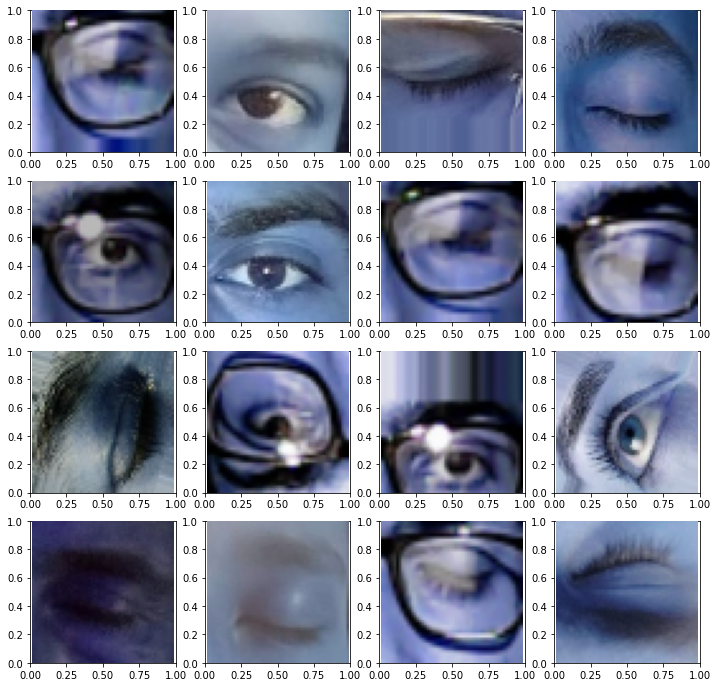

In [5]:
columns = 4
rows = 4
cr = 1

fig, axs = plt.subplots(rows, columns, figsize=(12, 12))
for r in range(1, rows+1):
    for c in range(1, columns+1):
          num = np.random.randint(len(imgs)-1)
          fig.add_subplot(rows, columns, cr)
          plt.axis('off')
          plt.imshow(imgs[num])
          cr = cr+1
plt.show()    

### Convert Images to Grayscale

In [6]:
#Function to convert images to grayscale
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.144])

# Run function on all images
cr = 0
for img in imgs:
  imgs[cr] = cv2.resize(rgb2gray(imgs[cr]),(PROCESS_IMAGE_SHAPE), interpolation=cv2.INTER_LINEAR)
  cr = cr+1

### Display Scaled Down Images and One Channel Images

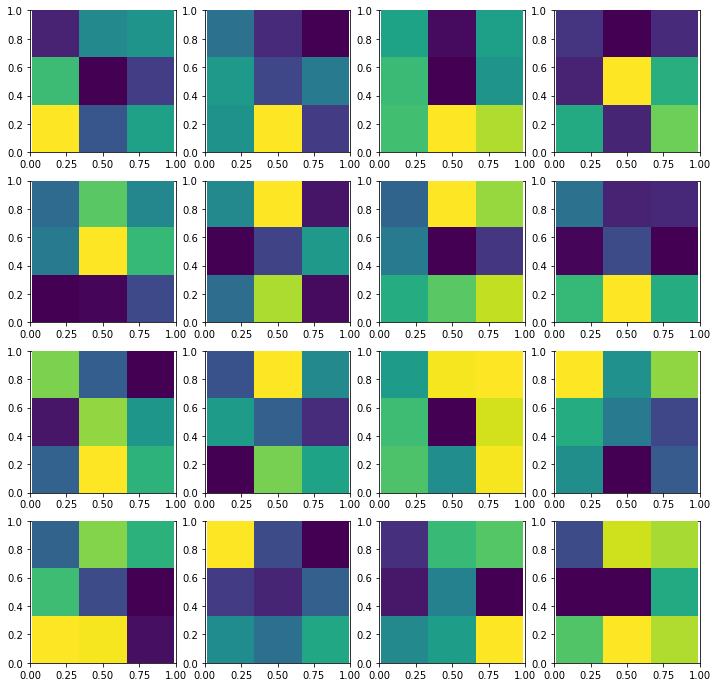

In [7]:
columns = 4
rows = 4
cr = 1

fig, axs = plt.subplots(rows, columns, figsize=(12, 12))
for r in range(1, rows+1):
    for c in range(1, columns+1):
          num = np.random.randint(len(imgs)-1)
          fig.add_subplot(rows, columns, cr)
          plt.axis('off')
          plt.imshow(imgs[num])
          cr = cr+1
plt.show()     

### Normalize Images

In [8]:
imgs_normalized = np.array(imgs)/255.0
imgs_normalized

array([[[3.85406152e-01, 3.20379379e-01, 2.70864337e-01],
        [5.01006532e-01, 6.10558824e-01, 4.31172524e-01],
        [7.60100285e-01, 7.46702361e-01, 7.47275245e-01]],

       [[6.72907879e-01, 1.17913741e-01, 6.86495815e-04],
        [4.34260785e-01, 3.74367647e-01, 3.00298547e-01],
        [6.44449130e-01, 5.63290579e-01, 5.21266651e-01]],

       [[3.19228873e-01, 2.05588300e-03, 2.35253666e-02],
        [1.94940206e-01, 1.10969608e-01, 1.44583413e-01],
        [2.90444763e-01, 5.12441837e-01, 4.06766318e-01]],

       ...,

       [[2.59196190e-01, 2.71520270e-01, 2.73948275e-01],
        [1.75544449e-01, 1.26963725e-01, 9.18607777e-02],
        [2.30511220e-01, 2.72726157e-01, 2.40380066e-01]],

       [[7.72558176e-01, 6.68190196e-01, 5.13071831e-01],
        [7.25433992e-01, 5.66058824e-01, 4.65002970e-01],
        [5.98629951e-01, 6.85669604e-01, 6.27906309e-01]],

       [[2.97517441e-01, 3.12585949e-01, 3.70512355e-01],
        [3.90321556e-01, 3.09610784e-01, 1.988663

### Flattening Images

To more efficiently use our memory resources we will flatten the image into a 1D shape.

In [9]:
# FLattening the images
imgs_normalized = imgs_normalized.reshape(imgs_normalized.shape[0], *(1,PROCESS_IMAGE_SIZE*PROCESS_IMAGE_SIZE,1))

### Binary Encode Image

We will have to further scale down our image into binary pixelated values due to the current restraints of quantum machine learning.

In [10]:
def binary_encode(X,threshold=0.5):
  """
  Encodes the given datset to use binary encoding

  Parameters:
  X(array) : Image data to be processed for encoding
  threshold(float): Threshold for binary encoding, 0.5 by default

  Returns:
  encoded_images(array): Binary encoded Image Data

  """ 
  encoded_images = list()
  for image in X:
    # pixel value is 1 if it's greater than threshold or else zero
    encoded_image = [1 if j>threshold else 0 for j in image[0]]
    encoded_images.append(encoded_image)
  return np.array(encoded_images)

binary_imgs = binary_encode(imgs_normalized)

### Divide Dataset into training, validation and testing set

In [11]:
# set aside 20% of train and test data for evaluation
X_train, X_test, y_train, y_test = train_test_split(binary_imgs, eye_stat, test_size=0.2, shuffle = True, random_state = 8)
X_train, X_val, y_train, y_val = train_test_split(binary_imgs, eye_stat, test_size=0.1, shuffle = True, random_state = 8)

### Create Quantum Circuit Function

In [12]:
# Creates a custom quantum circuit based on the input images
def create_circuit_from_image(encoded_image):
  qubits = cirq.GridQubit.rect(PROCESS_IMAGE_SIZE, PROCESS_IMAGE_SIZE)
  circuit = cirq.Circuit()
  for i, pixel in enumerate(encoded_image):
    if pixel:
      circuit.append(cirq.X(qubits[i]))
  return circuit

### Create Quantum Circuits for X_train, X_val and X_test

In [13]:
X_train = [create_circuit_from_image(encoded_image) for encoded_image in X_train]
X_val = [create_circuit_from_image(encoded_image) for encoded_image in X_val]
X_test = [create_circuit_from_image(encoded_image) for encoded_image in X_test]

### Convert Quantum Circuits to Tensors for Training

In [14]:
X_train_tfq = tfq.convert_to_tensor(X_train)
X_val_tfq = tfq.convert_to_tensor(X_val)
X_test_tfq = tfq.convert_to_tensor(X_test)

In [15]:
# Let's have a look at the circuit for the first image
print(X_train[0])

(1, 2): ───X───

(2, 1): ───X───


### Build the Quantum Neural Network

In [16]:
class QNN():
    def __init__(self, data_qubits, readout):
      self.data_qubits = data_qubits
      self.readout = readout

    def add_layer(self, circuit, gate, symbol_gate):
      """
      Adds New Gates/Layers to the Circuit
      Parameters:
      circuit(cirq.Circuit object): Cirq circuit
      gate(cirq gate): gate to append to the circuit
      symbol_gate(string): symbol for the gate
      Returns:
      None
      """
      for i, qubit in enumerate(self.data_qubits):
        symbol = sympy.Symbol(symbol_gate+ '-' + str(i))
        circuit.append(gate(qubit, self.readout)**symbol)

In [17]:
def create_qnn():
    """Create a QNN model circuit and readout operation to go along with it."""
    data_qubits = cirq.GridQubit.rect(2,2)  # a 4x4 grid.
    readout = cirq.GridQubit(-1, -1)         # a single qubit at [-1,-1]
    circuit = cirq.Circuit()

    # Prepare the readout qubit.
    circuit.append(cirq.X(readout))
    circuit.append(cirq.H(readout))

    qnn = QNN(
        data_qubits = data_qubits,
        readout=readout)
    
    # Add the ising coupling XX gate
    qnn.add_layer(circuit, cirq.XX, "xx")
    qnn.add_layer(circuit, cirq.ZZ, "zz")

    # Finally, prepare the readout qubit.
    circuit.append(cirq.H(readout))

    return circuit, cirq.Z(readout)

In [18]:
qmodel, model_readout = create_qnn()

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


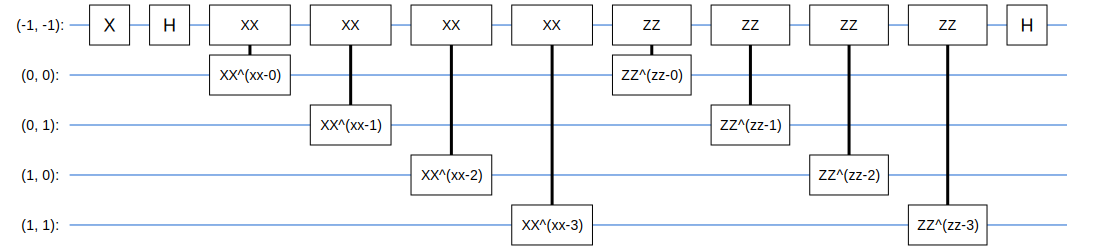

In [19]:
#Let's have a look at our Qauntum Circuit that will perform the classification
SVGCircuit(qmodel)

In [20]:
model = tf.keras.Sequential([                             
    # The input is the data-circuit, encoded as a tf.string
    tf.keras.layers.Input(shape=(), dtype=tf.string),
  
    # The PQC stands for Paramaterized Quantum Circuit
    # This returns the expectation value
    tfq.layers.PQC(qmodel, model_readout),
])

In [21]:
# To use Hinge Loss, we convert the labels to 1 and -1
y_train_h = np.array([1 if i==1 else -1 for i in y_train ])
y_val_h = np.array([1 if i==1 else -1 for i in y_val ])
y_test_h = np.array([1 if i==1 else -1 for i in y_test ])

In [22]:
# Define the custom Hinge Accuracy
def hinge_accuracy(y_true, y_pred):
    y_true = tf.squeeze(y_true) > 0.0
    y_pred = tf.squeeze(y_pred) > 0.0
    result = tf.cast(y_true == y_pred, tf.float32)

    return tf.reduce_mean(result)

### Train the QNN

In [23]:
model.compile(
    loss=tf.keras.losses.Hinge(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    metrics=[hinge_accuracy])

In [24]:
qnn_history = model.fit(
      X_train_tfq, y_train_h,
      batch_size=128,
      epochs=10,
      verbose=1,
      validation_data=(X_val_tfq, y_val_h))

Epoch 1/10
71/71 [==============================] - 6s 71ms/step - loss: 0.9284 - hinge_accuracy: 0.5473 - val_loss: 0.8316 - val_hinge_accuracy: 0.5869
Epoch 2/10
71/71 [==============================] - 5s 72ms/step - loss: 0.8462 - hinge_accuracy: 0.5768 - val_loss: 0.8280 - val_hinge_accuracy: 0.5869
Epoch 3/10
71/71 [==============================] - 5s 70ms/step - loss: 0.8431 - hinge_accuracy: 0.5794 - val_loss: 0.8280 - val_hinge_accuracy: 0.5869
Epoch 4/10
71/71 [==============================] - 5s 71ms/step - loss: 0.8511 - hinge_accuracy: 0.5740 - val_loss: 0.8280 - val_hinge_accuracy: 0.5869
Epoch 5/10
71/71 [==============================] - 5s 68ms/step - loss: 0.8487 - hinge_accuracy: 0.5747 - val_loss: 0.8280 - val_hinge_accuracy: 0.5869
Epoch 6/10
71/71 [==============================] - 5s 74ms/step - loss: 0.8484 - hinge_accuracy: 0.5765 - val_loss: 0.8280 - val_hinge_accuracy: 0.5869
Epoch 7/10
71/71 [==============================] - 5s 73ms/step - loss: 0.8453 - 

### Evaluate QNN Model

### Visualize the Results

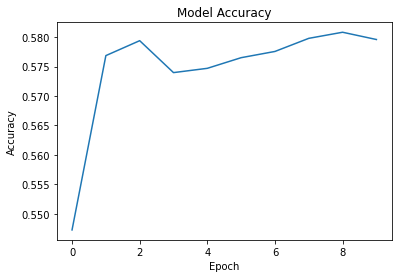

In [25]:
# Visualize Accuracy
plt.plot(qnn_history.history['hinge_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

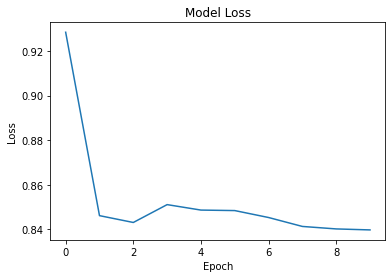

In [26]:
# Visualize Loss
plt.plot(qnn_history.history['loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

### Model Evaluation on Test Data

In [27]:
model.evaluate(X_test_tfq, y_test_h)

63/63 [==============================] - 1s 11ms/step - loss: 0.8070 - hinge_accuracy: 0.5967


[0.8069999814033508, 0.5967261791229248]

### Conclusions and Analysis

In the end our quantum classification model was able to correctly classify images of open and closed eyes 60% of the time. This is quite impressive when you consider our images were scaled down to pixels of 3x3 in one channel of binary values.

Realistically, this problem could be handled much better using classical machine learning but from studying deeper into quantum architecture we can see how quantum machine learning could be used for applications such as code breaking which would be a more rightful use case for this technology.

### References

^https://www.youtube.com/watch?v=JtsmoS7vXYA&t=1679s<br>
^https://www.kaggle.com/datasets/muhammadhananasghar/oace-open-and-close-eyes-dataset